# Auto Backtest Class
Consolidates all auto backtest functions into a class object

In [81]:
# Libraries
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import numpy as np
import plotly.express as px
from prophet import Prophet
import yfinance as yf
import itertools
import time
import random
from scipy import stats
from statsmodels.stats.weightstats import ztest


class autoBacktest:
    
    def __init__(self, stock, n_days, training_days, mov_avg, forecast_period, interval_width):
        
        # The stock chosen
        self.stock = stock
        
        # The number of days to backtest
        self.n_days = n_days
        
        # The number of days to train on
        self.training_days = training_days
        
        # The moving average to smooth out the data
        self.mov_avg = mov_avg
        
        # The number of days to predict
        self.forecast_period = forecast_period
        
        # Interval width for the model
        self.interval_width = interval_width
        
        # The backtest status
        self.status = {
            "Backtest Status": "Not yet started",
            "Next function to run": "getStockPrices()"
        }
        
    
    def getStockPrices(self):
        """
        Gets stock prices from now to N days ago and training amount will be in addition 
        to the number of days to train.
        """

        # Designating the Ticker
        ticker = yf.Ticker(self.stock)

        # Getting all price history
        price_history = ticker.history(period="max")

        # Check on length
        if len(price_history)<self.n_days+self.training_days+self.mov_avg:
            
            self.prices = pd.DataFrame() 
            self.price_history = price_history
            
            return

        # Getting relevant length
        prices = price_history.tail(self.n_days+self.training_days+self.mov_avg)

        # Filling NaNs with the most recent values for any missing data
        prices = prices.fillna(method='ffill')

        # Getting the N Day Moving Average and rounding the values for some light data preprocessing
        prices['MA'] = prices[['Close']].rolling(
            window=self.mov_avg
        ).mean().apply(lambda x: round(x, 2))

        # Resetting format for FBP
        prices = prices.reset_index().rename(
            columns={"Date": "ds", "MA": "y"}
        )

        # Dropping the Nans
        prices.dropna(inplace=True, subset=['y'])

        # Setting variables
        self.prices = prices
            
        self.price_history = price_history
        
        self.status = {
            "Backtest Status": "Prices retrieved successfully!",
            "Next function to run": "runningFBP()"
        }
                
        return self.status
    
    
    def fbpTrainPredict(self, prices, forecast_period, interval_width=0.80):
        """
        Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
        the future based on given forecast period. Returns predicted values as a DF.
        """
        
        # Setting up prophet
        m = Prophet(
            daily_seasonality=True, 
            yearly_seasonality=True, 
            weekly_seasonality=True,
            interval_width=interval_width
        )

        # Fitting to the prices
        m.fit(prices[['ds', 'y']])

        # Future DF
        future = m.make_future_dataframe(
            periods=forecast_period,
            freq='B',
            include_history=False
        )

        # Predicting values
        forecast = m.predict(future)

        # Returning a set of predicted values
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        
    
    def runningFBP(self):
        """
        Runs Facebook Prophet to get predictions over a set period 
        of time. Uses FBP to train and predict every N days and gets the 
        price forecasts.
        """        
        # Variables used
        forecast_period = self.forecast_period
        
        training_days = self.training_days
        
        prices = self.prices
        
        # DF for the predicted values
        pred_df = pd.DataFrame()

        # Running the model each day
        for i in tqdm(range(training_days, len(prices)+1), leave=False):

            # Training then Predicting the last day of the forecast
            forecast = self.fbpTrainPredict(
                prices[i-training_days:i], 
                forecast_period,
                interval_width=self.interval_width
            ).tail(1)

            # Adding the forecast predicted (last day)
            pred_df = pred_df.append(forecast, ignore_index=True)

        # Prepping for merge by converting date values to be the same type
        pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

        prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])

        # Shifting the forecasts back in order to compare it to the 'current' open values
        pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)

        # Merging with the prices DF in order to compare values for positions later
        merge_df = prices[['ds', 'Open']].merge(
            pred_df,
            on='ds',
            how='outer'
        ).dropna().set_index('ds')

        self.pred_df = merge_df
        
        self.status = {
            "Backtest Status": "Facebook Prophet ran successfully",
            "Next function to run": "performBacktest()"
        }
        
        return self.status 
        
    
    def fbpPositions(self, pred_df, short=True):
        """
        Gets positions based on the predictions and the actual values.
        """
        if pred_df['Open'] < pred_df['yhat_lower']:
            return 1
        elif pred_df['Open'] > pred_df['yhat_upper'] and short:
            return -1
        else:
            return 0
        

    def performBacktest(self):
    
        # Adding positions to the forecast DF
        positions = self.pred_df

        # Getting forecast prophet positions 
        positions['fbp_positions'] = positions.apply(
            lambda x: self.fbpPositions(x, short=True), 
            axis=1
        )

        # Buy and hold position
        positions['buy_hold'] = 1
        
        # Assigning the prediction DF as the newly 
        self.pred_df = positions

        # Getting daily returns
        log_returns = self.prices[['ds', 'Close']].set_index(
            'ds'
        ).loc[positions.index].apply(np.log).diff()

        # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
        bt_positions = positions[[
            'buy_hold', 
            'fbp_positions'
        ]].shift(1)

        # The returns during the backtest
        returns = bt_positions.multiply(
            log_returns['Close'], 
            axis=0
        )

        # Inversing the log returns to get daily portfolio balance
        self.performance = returns.cumsum().apply(
            np.exp
        ).dropna().fillna(
            method='ffill'
        )
        
        self.status = {
            "Backtest Status": "Backtest ran successfully!",
            "Next function to run": "performanceAnalysis()"
        }
        
        return self.status
        
        
    def performanceAnalysis(self):
        """
        Analyzes the performance DataFrame to calculate various
        evaluation metrics on the backtest to determine if
        the backtest performance was favorable.
        """
        ### Hypothesis testing average returns

        # Weekly returns for fb prophet
        rets = self.performance['fbp_positions'].pct_change(5).dropna()

        # Buy and hold for about the last two years for the stock
        hold = self.price_history['Close'].tail(500).apply(np.log).diff().cumsum().apply(np.exp).dropna()

        # Weekly returns in those years
        hold_ret = hold.pct_change(5).mean()

        # Average returns
        if len(self.performance)<=30:
            # T-testing
            stat_test = stats.ttest_1samp(
                rets, 
                popmean=hold_ret,
                alternative='greater'
            )
        else:
            # Z-testing
            stat_test = ztest(
                rets, 
                value=hold_ret,
                alternative='larger'
            )

        # Ending portfolio balance
        bal = self.performance.tail(1)

        # Moving Average returns
        ma_ret = self.performance.rolling(window=5).mean().dropna()

        # How often fbp beats holding
        ma_ret['diff'] = ma_ret['fbp_positions'] > ma_ret['buy_hold']

        diff = ma_ret['diff'].mean()

        # How often the fbp portfolio had a balance greater than its initial balance
        ma_ret['beat_bal'] = ma_ret['fbp_positions'] > 1

        beat_bal = ma_ret['beat_bal'].mean()

        # How often fbp MA returns were positive
        ma_ret['uptrend'] = ma_ret['fbp_positions'].diff().dropna()>=0

        uptrend = ma_ret['uptrend'].mean()

        # Performance score
        score = 0

        # P-value check
        if stat_test[1]<0.05:
            score += 1

        # Checking ending portfolio balance
        if bal['fbp_positions'][0]>bal['buy_hold'][0] and bal['fbp_positions'][0]>1: 
            score += 1

        # How often fbp outperformed buy and hold
        if diff>.55: 
            score += 1

        # How often fbp had returns greater than the initial portfolio balance
        if beat_bal>.55: 
            score += 1

        # How often fbp had positive upward trend
        if uptrend>.55:
            score += 1

        # Dictionary containing values
        self.analysis_results = {
            "result": True,
            "score": score,
            "endingBalance": {
                "prophet": bal['fbp_positions'][0],
                "buyHold": bal['buy_hold'][0]
            },
            "betterThanBuyHold": diff,
            "greaterPortfolioBalance": beat_bal,
            "upwardTrend": uptrend,
            "pValue": stat_test[1],
            "interval_width": self.interval_width
        }

        if score>=5:
            
            self.analysis_results['result'] = False
            
        self.status = {
            "Backtest Status": "Analysis ran successfully!",
            "Next function to run": "visualizePerformance()"
        }
        
        print(self.analysis_results)
        
        return self.status
    
    
    def visualizePerformance(self):
        
        performance = self.performance
        
        # Visualizing results
        fig = px.line(
            performance,
            x=performance.index,
            y=performance.columns,
            title=f'FBProphet vs Buy&Hold for {self.stock}',
            labels={"value": "Portfolio Balance",
                    "index": "Date"}
        )

        return fig.show()
    
    
    def runCompleteBacktest(self):
        
        print("Getting prices...")
        
        self.getStockPrices()
        
        print("Initializing Facebook Prophet...")
        
        self.runningFBP()
        
        print("Performing Backtest...")
        
        self.performBacktest()
        
        print("Running Analysis...")
        
        self.performanceAnalysis()
        
        print("Visualizing results:")
        
        self.visualizePerformance()
        
        

# Testing AutoBacktest

In [82]:
ab = autoBacktest(
    stock="MSFT", 
    n_days=35, 
    training_days=100, 
    mov_avg=5, 
    forecast_period=5,
    interval_width=.80
)

In [84]:
ab.status

{'Backtest Status': 'Not yet started',
 'Next function to run': 'getStockPrices()'}

In [85]:
ab.getStockPrices()

{'Backtest Status': 'Prices retrieved successfully!',
 'Next function to run': 'runningFBP()'}

In [88]:
ab.runningFBP()

  0%|          | 0/37 [00:00<?, ?it/s]

{'Backtest Status': 'Facebook Prophet ran successfully',
 'Next function to run': 'performBacktest()'}

In [89]:
ab.performBacktest()

{'Backtest Status': 'Backtest ran successfully!',
 'Next function to run': 'performanceAnalysis()'}

In [90]:
ab.performanceAnalysis()

{'result': True, 'score': 4, 'endingBalance': {'prophet': 1.0456292894950363, 'buyHold': 0.9646670462819342}, 'betterThanBuyHold': 0.6538461538461539, 'greaterPortfolioBalance': 0.5769230769230769, 'upwardTrend': 0.64, 'pValue': 0.11807316164471934, 'interval_width': 0.8}


{'Backtest Status': 'Analysis ran successfully!',
 'Next function to run': 'visualizePerformance()'}

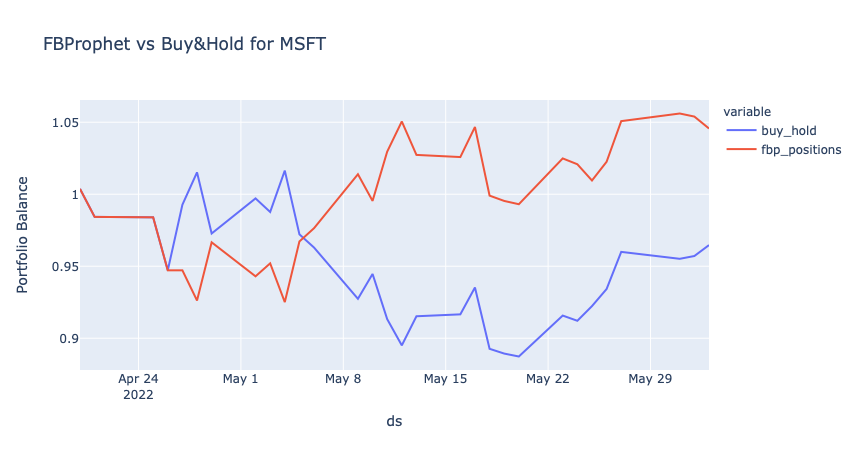

In [91]:
ab.visualizePerformance()

Getting prices...
Initializing Facebook Prophet...


  0%|          | 0/37 [00:00<?, ?it/s]

Performing Backtest...
Running Analysis...
{'result': True, 'score': 4, 'endingBalance': {'prophet': 1.0456292894950363, 'buyHold': 0.9646670462819342}, 'betterThanBuyHold': 0.6538461538461539, 'greaterPortfolioBalance': 0.5769230769230769, 'upwardTrend': 0.64, 'pValue': 0.1180731665614141, 'interval_width': 0.8}
Visualizing results:


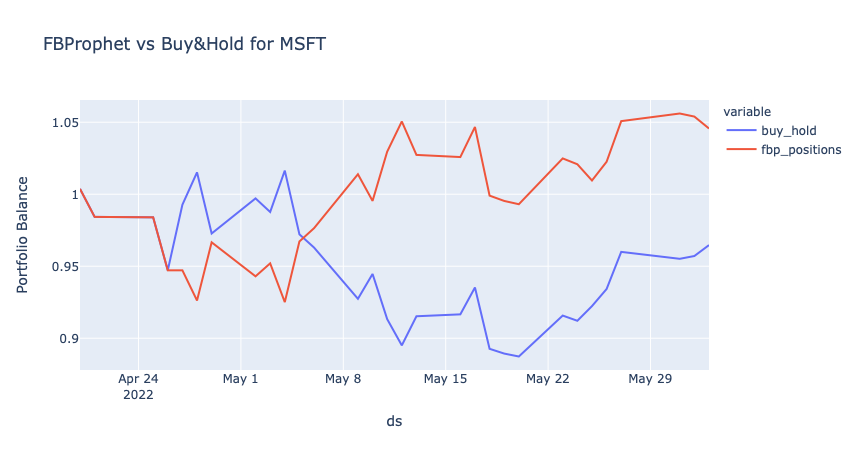

In [92]:
ab.runCompleteBacktest()